<a href="https://colab.research.google.com/github/fvgm-spec/coderoad-de-bootcamp/blob/main/Highest_performing_stores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Identify the highest-performing stores and its top product

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import warnings
warnings.filterwarnings('ignore')

# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Paths to the datasets
products_path = '/content/drive/My Drive/data/PRODUCTS_.csv'
sales_path = '/content/drive/My Drive/data/SALES_.csv'
soh_path = '/content/drive/My Drive/data/SOH_.csv'

In [7]:
# Read the data
products_df = pd.read_csv(products_path)
sales_df = pd.read_csv(sales_path)
soh_df = pd.read_csv(soh_path)

In [9]:
# Clean the data - ensure numeric columns are properly typed
sales_df['sku'] = pd.to_numeric(sales_df['sku'], errors='coerce')
sales_df['sales_qty'] = pd.to_numeric(sales_df['sales_qty'], errors='coerce')

In [10]:
# Create a product lookup dictionary for faster joining
product_lookup = {}
for _, row in products_df.iterrows():
    product_lookup[row['gtin']] = {
        'product_name': row['productLabelLong'],
        'category': row['categoryParent']
    }
    product_lookup[row['productCode']] = {
        'product_name': row['productLabelLong'],
        'category': row['categoryParent']
    }

In [12]:
# Filter out null SKUs
valid_sales_df = sales_df.dropna(subset=['sku'])

In [13]:
# 1. Analyze sales by store
store_sales = valid_sales_df.groupby('site_code')['sales_qty'].sum().reset_index()
store_sales = store_sales.sort_values('sales_qty', ascending=False)
top_10_stores = store_sales.head(10)

# 2. Analyze sales by product
product_sales = valid_sales_df.groupby('sku')['sales_qty'].sum().reset_index()
product_sales = product_sales.sort_values('sales_qty', ascending=False)
top_10_products = product_sales.head(10)

In [14]:
# Add product names to the top products
top_10_products['product_name'] = top_10_products['sku'].apply(
    lambda x: product_lookup.get(x, {}).get('product_name', 'Unknown Product')
)
top_10_products['category'] = top_10_products['sku'].apply(
    lambda x: product_lookup.get(x, {}).get('category', 'Unknown Category')
)

In [15]:
# 3. Analyze sales by category
def get_category(sku):
    return product_lookup.get(sku, {}).get('category', 'Unknown Category')

valid_sales_df['category'] = valid_sales_df['sku'].apply(get_category)
category_sales = valid_sales_df.groupby('category')['sales_qty'].sum().reset_index()
category_sales = category_sales.sort_values('sales_qty', ascending=False)
top_10_categories = category_sales.head(10)

# 4. Get top product for each top 5 store
top_5_stores = top_10_stores.head(5)['site_code'].tolist()
top_products_by_store = []

In [17]:
for store in top_5_stores:
    store_data = valid_sales_df[valid_sales_df['site_code'] == store]
    product_sales = store_data.groupby('sku')['sales_qty'].sum().reset_index()

    if not product_sales.empty:
        top_product = product_sales.sort_values('sales_qty', ascending=False).iloc[0]
        sku = top_product['sku']

        top_products_by_store.append({
            'store_code': store,
            'sku': sku,
            'total_sales': top_product['sales_qty'],
            'product_name': product_lookup.get(sku, {}).get('product_name', 'Unknown Product'),
            'category': product_lookup.get(sku, {}).get('category', 'Unknown Category')
        })

top_products_by_store_df = pd.DataFrame(top_products_by_store)

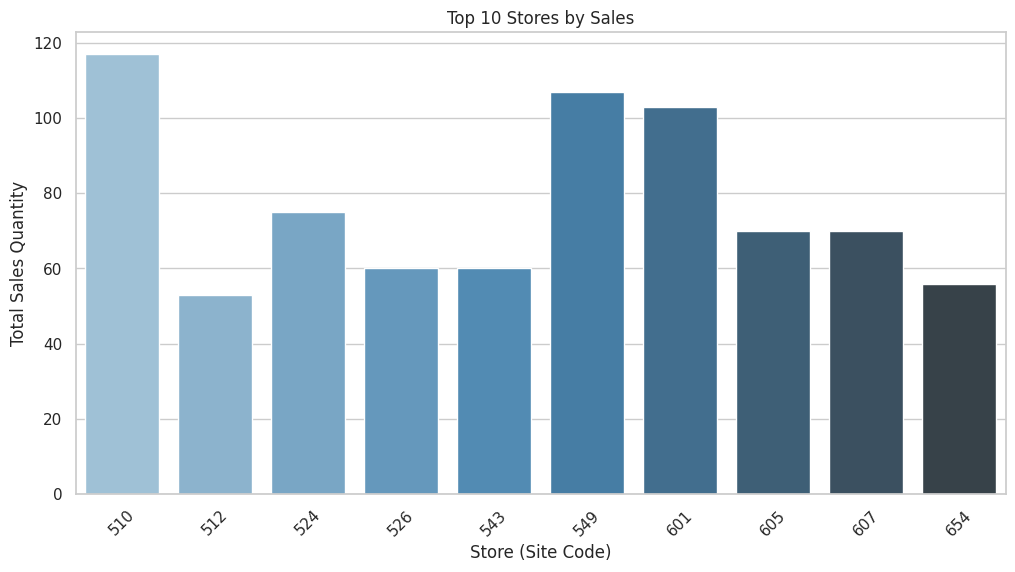

In [18]:
# -------------- Visualization ----------------

# Top 10 Stores by Sales
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_stores, x='site_code', y='sales_qty', palette="Blues_d")
plt.xlabel("Store (Site Code)")
plt.ylabel("Total Sales Quantity")
plt.title("Top 10 Stores by Sales")
plt.xticks(rotation=45)
plt.show()

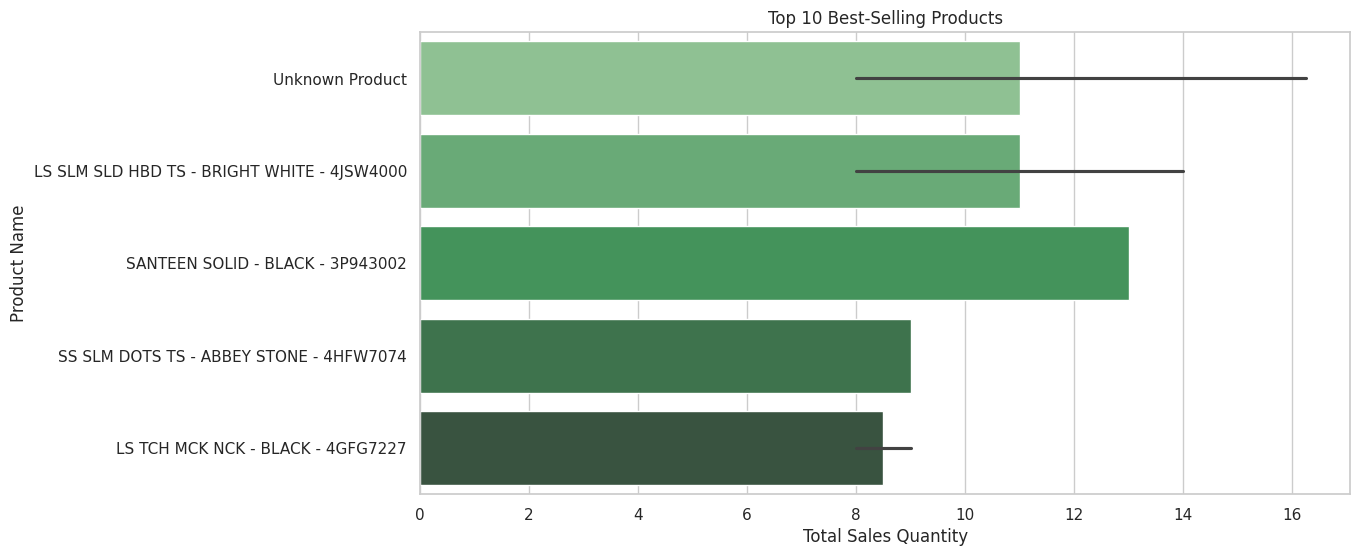

In [19]:
# Top 10 Products by Sales
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_products, y='product_name', x='sales_qty', palette="Greens_d")
plt.xlabel("Total Sales Quantity")
plt.ylabel("Product Name")
plt.title("Top 10 Best-Selling Products")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

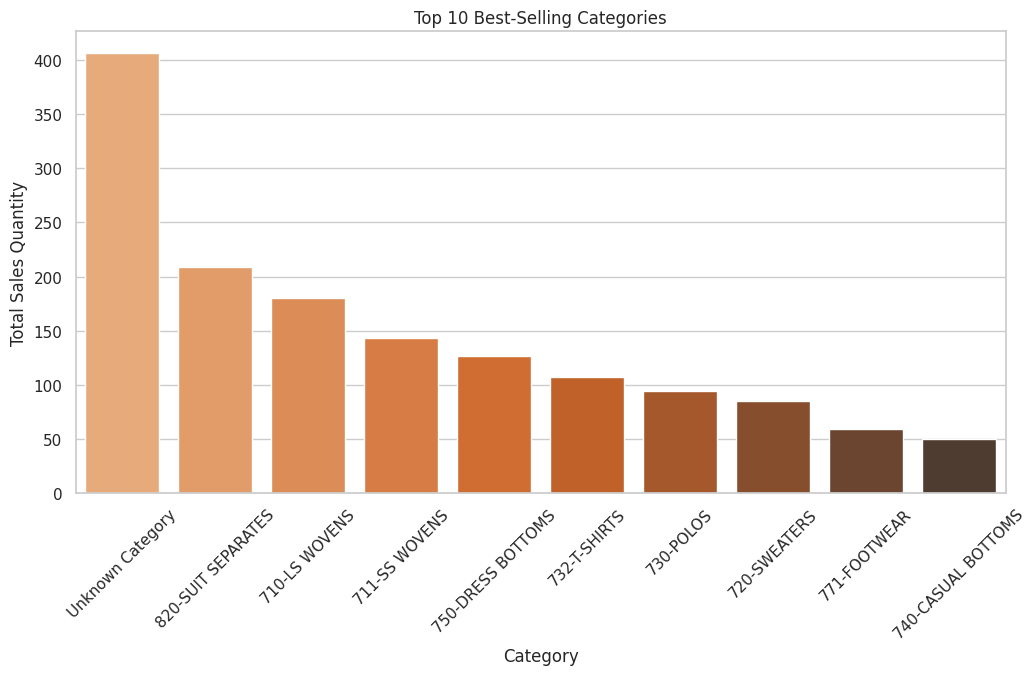

In [20]:
# Top 10 Categories by Sales
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_categories, x='category', y='sales_qty', palette="Oranges_d")
plt.xlabel("Category")
plt.ylabel("Total Sales Quantity")
plt.title("Top 10 Best-Selling Categories")
plt.xticks(rotation=45)
plt.show()

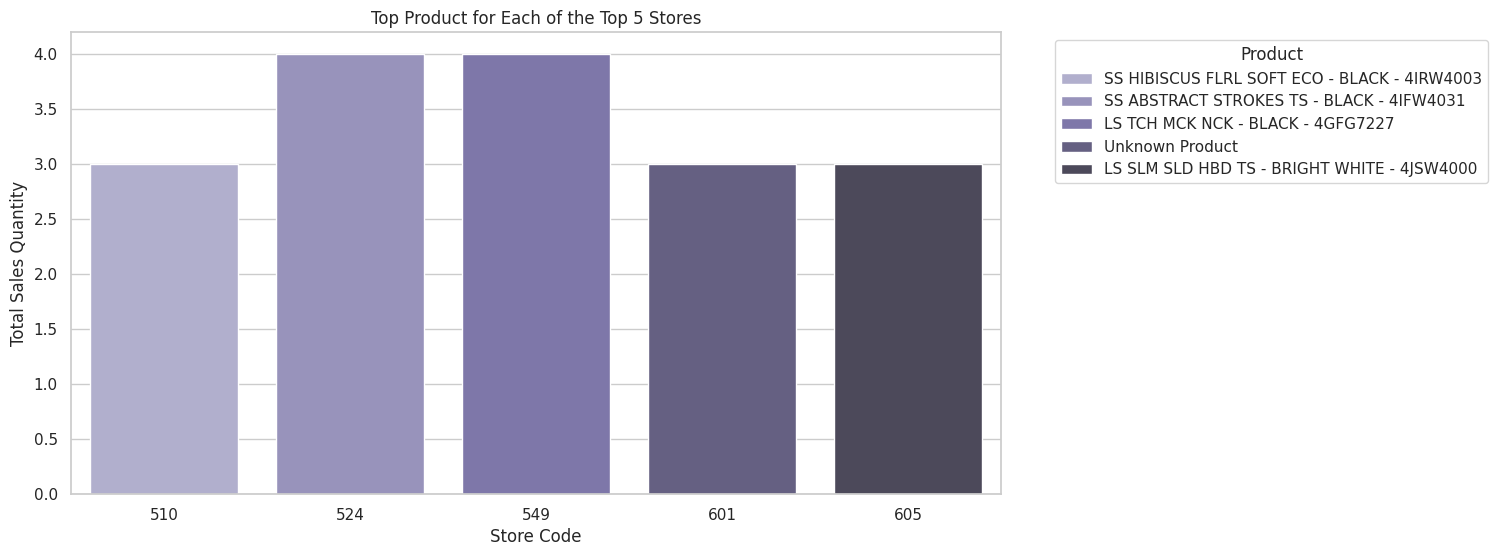

In [21]:
# Top Product for Each of the Top 5 Stores
plt.figure(figsize=(12, 6))
sns.barplot(data=top_products_by_store_df, x='store_code', y='total_sales', hue='product_name', palette="Purples_d")
plt.xlabel("Store Code")
plt.ylabel("Total Sales Quantity")
plt.title("Top Product for Each of the Top 5 Stores")
plt.legend(title="Product", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()